# Machine Learning Methods for Diabetes Diagnosis: A Non-Glycemic Biomarker Exploration
### Master's thesis of the master's degree in Bioinformatics and Biostatistics of the UB and the UOC
- Author: Carlos Colmenero Gómez Cambronero

## Data pre-processing

### Import libraries

In [59]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning - Preprocessing and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, classification_report

# Machine Learning - Models
from catboost import CatBoostClassifier

# Parameter optimization
from scipy.stats import uniform, randint

# ... existing code ...

### Load the data

In [5]:
# Load the data set
file_path = "../data/dataset_diabetes.csv"
headers = pd.read_csv(file_path, nrows=0).columns.tolist()
data = pd.read_csv(file_path, usecols=headers[1:])
data.head()

,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


### Check the data types
There are 2 categorical variables (represented with objects), whereas the other variables are numeric, either integer (patient number, age and creatinine) or float (the remaining numerical variables).

In [6]:
data.dtypes

No_Pation      int64
Gender        object
AGE            int64
Urea         float64
Cr             int64
HbA1c        float64
Chol         float64
TG           float64
HDL          float64
LDL          float64
VLDL         float64
BMI          float64
CLASS         object
dtype: object

### Check the original shape of the data
The original data has 1000 observations (rows) and 13 columns (11 features plus the patient number and the diagnosis class)

In [7]:
data.shape

(1000, 13)

### Rename columns
Rename some columns to be more informative

In [8]:
data = data.rename(columns={'CLASS': 'Diagnosis',
                            'Gender': 'Sex',
                            'AGE': 'Age',
                            'No_Pation': 'Num_Patient'})

### Check missing values
There are no missing values in the dataset

In [9]:
# Check for missing values of each column
data.isna().sum()

Num_Patient    0
Sex            0
Age            0
Urea           0
Cr             0
HbA1c          0
Chol           0
TG             0
HDL            0
LDL            0
VLDL           0
BMI            0
Diagnosis      0
dtype: int64

### Check data consistency

Check if  the categories have been correctly labeled

In [10]:
# Split variables names by their type (categorical or numerical)
categorical_vars = [var for var in data.columns if (data[var].dtype == 'object')]
numerical_vars = [var for var in data.columns if (data[var].dtype in ['int64', 'float64']) and (var != 'Num_Patient')]

# Check the categories of categorical variables
for categorical_var in categorical_vars:
    print(f'{categorical_var}: {np.unique(data[categorical_var])}\n')

Sex: ['F' 'M' 'f']

Diagnosis: ['N' 'N ' 'P' 'Y' 'Y ']



There are some values that actually represent the same category due to accidental spaces or different capitalization. Thus, they will be unified.

In [11]:
# Unify the categories that refer to the same level
data['Sex'] = data['Sex'].str.replace('f', 'F')
data['Diagnosis'] = data['Diagnosis'].str.strip()

In [12]:
# Rename the categories to be more informative
data['Diagnosis'] = data['Diagnosis'].replace({'Y': 'Diabetes', 'N': 'Non-diabetes', 'P': 'Prediabetes'})
data['Sex'] = data['Sex'].replace({'M': 'Male', 'F': 'Female'})

In [13]:
# Check that the categories have been correctly unified and renamed
for categorical_var in categorical_vars:
    print(f'{categorical_var}: {np.unique(data[categorical_var])}\n')

Sex: ['Female' 'Male']

Diagnosis: ['Diabetes' 'Non-diabetes' 'Prediabetes']



Check if the patient number is unique

In [14]:
# Get the value counts
patient_number_counts = data['Num_Patient'].value_counts()

# Get the non-unique patient numbers
non_unique_patient_numbers = patient_number_counts[patient_number_counts > 1].index

# Filter the data for the non-unique patient numbers
data_non_unique_patient_numbers = data[data['Num_Patient'].isin(non_unique_patient_numbers)]

# Check the shape of the data with non-unique patient numbers
data_non_unique_patient_numbers['Num_Patient'].value_counts()

Num_Patient
454316    19
87654      2
34290      2
34517      2
14389      2
24033      2
34325      2
23972      2
2345       2
34516      2
44835      2
234        2
34514      2
345        2
856        2
34515      2
34518      2
34545      2
45370      2
48362      2
71741      2
45646      2
Name: count, dtype: int64

In [15]:
# Check the data of some non-unique patient numbers to see it their data is coherent
data_non_unique_patient_numbers[data_non_unique_patient_numbers['Num_Patient'] == 454316]

,Num_Patient,Sex,Age,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Diagnosis
96,454316,Female,54,6.3,106,5.6,4.3,2.0,1.3,2.2,0.9,20.0,Non-diabetes
97,454316,Female,50,3.3,70,4.9,3.7,0.9,1.2,2.7,0.6,24.0,Non-diabetes
98,454316,Male,60,7.5,70,0.9,3.4,5.3,1.1,3.6,0.8,24.0,Non-diabetes
99,454316,Male,77,5.0,106,5.4,0.0,2.8,0.8,1.8,0.7,19.0,Non-diabetes
100,454316,Female,59,4.7,58,4.1,4.5,1.8,1.8,1.8,1.3,22.5,Non-diabetes
101,454316,Female,57,4.6,97,0.9,3.2,1.3,0.9,3.0,1.1,22.0,Non-diabetes
981,454316,Male,65,5.0,97,7.0,4.3,4.3,1.4,1.5,2.0,27.0,Diabetes
982,454316,Female,54,5.0,88,6.8,5.1,2.1,1.1,3.0,1.0,30.0,Diabetes
983,454316,Male,64,8.8,106,8.5,5.9,2.1,1.2,4.0,1.2,32.0,Diabetes
984,454316,Female,60,5.0,70,8.1,5.2,3.3,1.4,0.6,3.0,27.0,Diabetes


In [16]:
data_non_unique_patient_numbers[data_non_unique_patient_numbers['Num_Patient'] == 87654]

,Num_Patient,Sex,Age,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Diagnosis
17,87654,Female,30,3.0,42,4.1,4.9,1.3,1.2,3.2,0.5,22.0,Non-diabetes
997,87654,Male,30,7.1,81,6.7,4.1,1.1,1.2,2.4,8.1,27.4,Diabetes


The patient number, that should identify the patients, is not unique. If some observations with the same patient number are checked, it can be seen that the observations have values that are not compatible with each other (for instance, being female and male). Thus, the observations with the repeated patient numbers are considered mistakes and are deleted.

In [17]:
# Since the data is not coheret, remove the rows where the patient number is repeated
data = data[~data['Num_Patient'].isin(non_unique_patient_numbers)]

# Check the shape of the data after removing the rows with non-unique patient numbers
data.shape

(939, 13)

### Exploratory Data Analysis

 Show main statistics of numerical variables

In [119]:
data.drop('Num_Patient', axis=1).describe()

,Age,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
count,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000
mean,53.373802,5.073464,67.168264,8.284984,4.849223,2.324505,1.208892,2.606486,1.873908,29.616954
std,8.707874,2.801364,51.137482,2.533044,1.286454,1.396236,0.677571,1.120413,3.746397,4.997534
min,20.000000,0.500000,6.000000,0.900000,0.500000,0.300000,0.200000,0.300000,0.100000,19.000000
25%,51.000000,3.660000,48.000000,6.500000,4.000000,1.400000,0.900000,1.800000,0.700000,26.000000
50%,55.000000,4.600000,60.000000,8.000000,4.800000,2.000000,1.100000,2.500000,0.900000,30.000000
75%,59.000000,5.700000,73.000000,10.200000,5.600000,2.900000,1.300000,3.300000,1.500000,33.000000
max,79.000000,38.900000,800.000000,16.000000,10.300000,13.800000,9.900000,9.900000,35.000000,47.750000


Check the frequency distribution of categorical variables

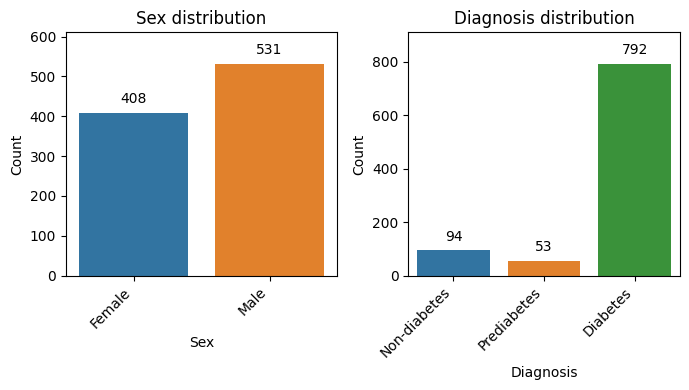

In [120]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

# For each categorical variable
for i, var in enumerate(categorical_vars):

    # Plot the frequency distribution
    ax = sns.countplot(x=var, hue=var, data=data, ax=axes[i], legend=False)

    # Display the count above each bar
    for p in ax.patches:
        ax.annotate(round(p.get_height()), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')

    # Set the title and labels
    axes[i].set_title(var + ' distribution')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

    # Rotate the x-axis labels for better visualization
    axes[i].tick_params(axis='x', rotation=45)
    for tick in axes[i].get_xticklabels():
        tick.set_horizontalalignment('right')

    # Set the y-axis limit to a higher value
    axes[i].set_ylim([0, max([p.get_height() for p in ax.patches])*1.15])
    

# Adjust the layout
plt.tight_layout()

# Save the figure to SVG
fig.savefig('figures/categorical_variables_distribution.svg')

# Show the figure
plt.show()

Check the distribution of numerical variables through histograms

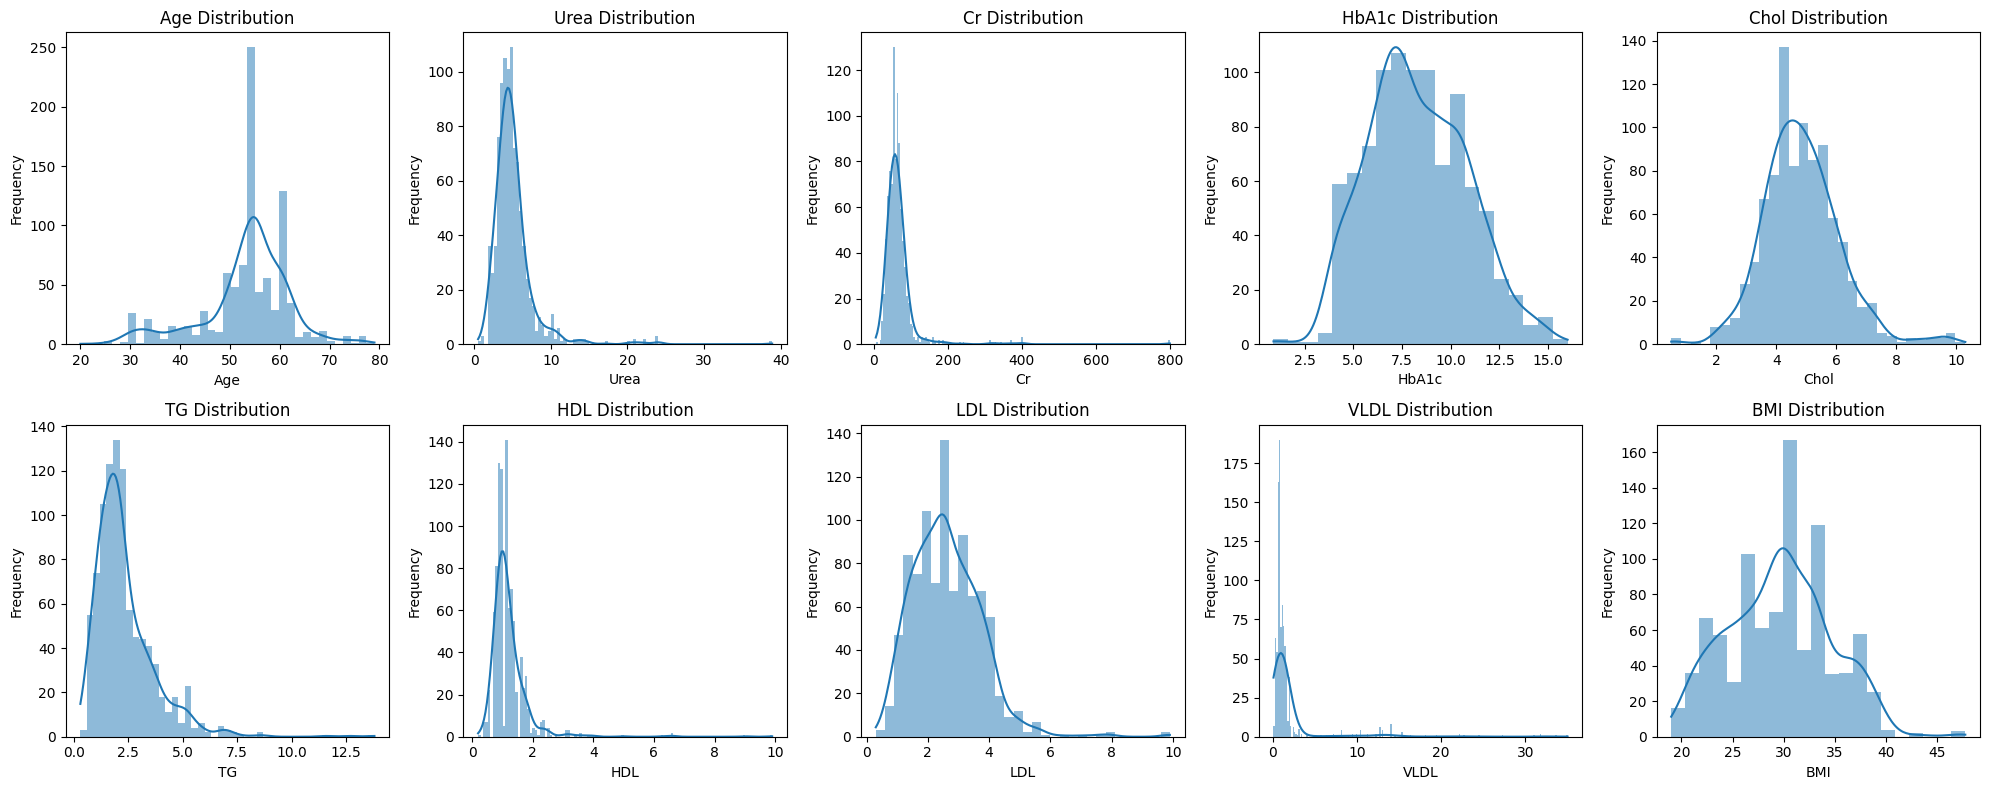

In [121]:
def plot_histograms(vars):
 
    # Create the figure
    fig, axes = plt.subplots(len(vars)//5, 5, figsize=(20, 8 if len(vars)>5 else 4))

    # Flatten the axes array for easier access
    axes = axes.flatten()

    # For each numerical variable
    for i, var in enumerate(vars):

        # Plot the histogram with a kernel density estimate
        sns.histplot(data[var], kde=True, edgecolor='none', ax=axes[i])

        # Set the labels and title
        axes[i].set_title(var + ' Distribution')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Frequency')

    # Adjust the layout
    plt.tight_layout()

    # Save the figure to SVG
    fig.savefig('figures/numerical_variables_distribution.svg')

    # Show the figure
    plt.show()


plot_histograms(numerical_vars)

### Feature engineering

Create new features that are mainly ratios of other features and based on the literature could be useful to identify diabetes and prediabetes

In [122]:
# TG / HDL
data['TG/HDL'] = data['TG'] / data['HDL']

# Chol / HDL
data['Chol/HDL'] = data['Chol'] / data['HDL']

# Non-HDL (Total - HDL)
data['Non-HDL'] = data['Chol'] - data['HDL']

# LDL / HDL
data['LDL/HDL'] = data['LDL'] / data['HDL']

# Urea / Cr
data['Urea/Cr'] = data['Urea'] / data['Cr']

# Show the first observations, including the new features
data.head()

,Num_Patient,Sex,Age,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Diagnosis,TG/HDL,Chol/HDL,Non-HDL,LDL/HDL,Urea/Cr
0,17975,Female,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,Non-diabetes,0.375000,1.750000,1.8,0.583333,0.102174
1,34221,Male,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,Non-diabetes,1.272727,3.363636,2.6,1.909091,0.072581
2,47975,Female,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,Non-diabetes,0.375000,1.750000,1.8,0.583333,0.102174
3,87656,Female,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,Non-diabetes,0.375000,1.750000,1.8,0.583333,0.102174
4,34223,Male,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,Non-diabetes,1.250000,6.125000,4.1,2.500000,0.154348


Show the distribution of the new created features

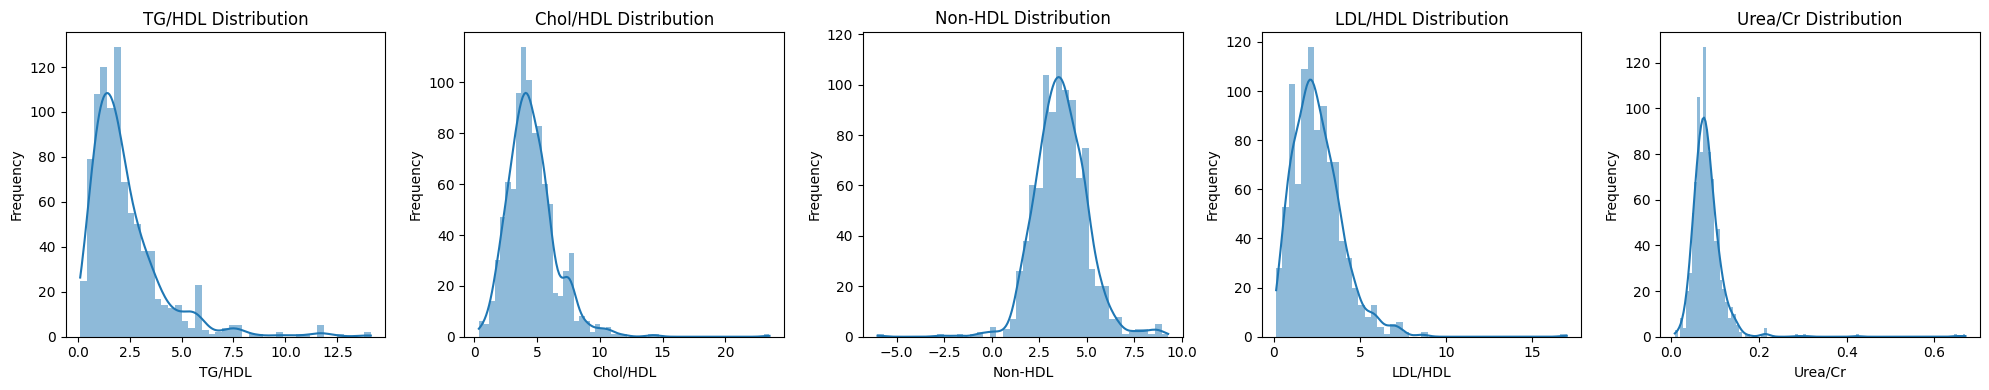

In [123]:
plot_histograms(data.columns[-5:])

### Separating the test dataset and defining the evaluate function

In [19]:
dataX = data.drop(['Diagnosis', 'Num_Patient', 'HbA1c'], axis=1)
y = data['Diagnosis']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(dataX, y, test_size=0.2, stratify=y, random_state=42)

In [23]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
print("Categorical features in X_train:", categorical_features)


Categorical features in X_train: ['Sex']


In [ ]:
def evaluate_model(model, X_test, y_test, title='Confusion Matrix'):
    '''
    Function to evaluate the model without using the encoder
    '''

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    conf_matrix_display.plot(cmap='Blues')
    plt.title(title)
    plt.show()

    # Compute accuracy, and macro average precision, recall and F1-score
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')

    # Create a DataFrame with the metrics
    metrics = {'Macro-average F1 Score': f1_macro, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall}
    metrics = pd.DataFrame([metrics])

    return metrics

### Castboot without SMOTE

In [54]:
from catboost import CatBoostClassifier

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='MultiClass',
                                    cat_features=categorical_features, random_seed=42, auto_class_weights='Balanced')

# Fit the model
catboost_model.fit(X_train, y_train, verbose=0)

# Predict on the test set
y_pred = catboost_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Diabetes       0.99      0.99      0.99       158
Non-diabetes       0.75      0.95      0.84        19
 Prediabetes       0.67      0.36      0.47        11

    accuracy                           0.95       188
   macro avg       0.80      0.77      0.77       188
weighted avg       0.94      0.95      0.94       188



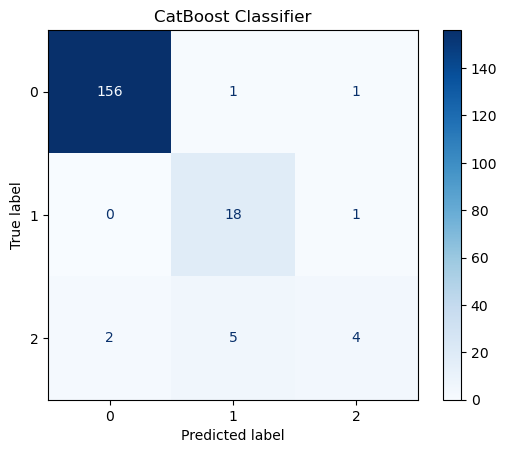

,Macro-average F1 Score,Accuracy,Precision,Recall
0,0.765046,0.946809,0.801336,0.766116


In [55]:
evaluate_model(catboost_model, X_test, y_test, title='CatBoost Classifier')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:
{'bagging_temperature': 0.7219987722668247, 'border_count': 189, 'depth': 9, 'iterations': 485, 'l2_leaf_reg': 2.818249672071006, 'learning_rate': 0.06502135295603015, 'random_strength': 7.0848448591907545}

Best cross-validation score: 0.8545


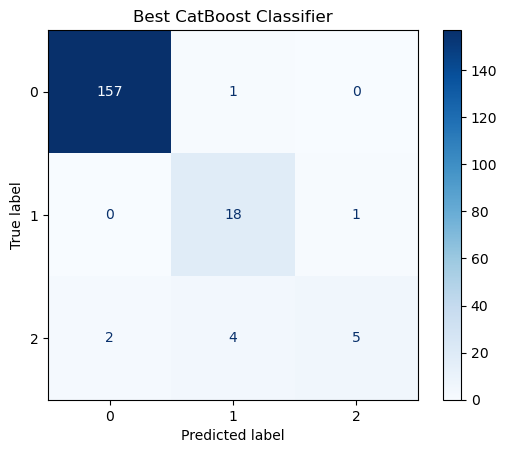


Best CatBoost model performance:
   Macro-average F1 Score  Accuracy  Precision    Recall
0                0.811971  0.957447   0.867788  0.798528


In [58]:
# Perform hyperparameter tuning for CatBoost using cross-validation

from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.3),
    'iterations': randint(100, 1000),
    'l2_leaf_reg': uniform(1, 10),
    'border_count': randint(32, 255),
    'bagging_temperature': uniform(0, 1),
    'random_strength': uniform(1, 20)
}

# Initialize the CatBoost classifier
catboost_model = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='MultiClass',
    task_type='CPU',
    random_seed=42,
    cat_features=categorical_features,
    # auto_class_weights='Balanced'
)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,  # Use all available cores
    random_state=42,
    scoring='f1_macro'  # Use macro F1 score as the metric for the search
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train, verbose=0)

# Print the best parameters and score
print("Best parameters found:")
print(random_search.best_params_)
print("\nBest cross-validation score: {:.4f}".format(random_search.best_score_))

# Get the best model
best_catboost_model = random_search.best_estimator_

# Evaluate the best model
best_metrics = evaluate_model(best_catboost_model, X_test, y_test, title='Best CatBoost Classifier')
print("\nBest CatBoost model performance:")
print(best_metrics)
